# ***Computer Vision Final Project: Breast Cancer Tumor Classification***
## Section 1 Spring 2023
### Nicholas Lee, Nic Brathwaite, Amir Moayed

# Baseline Models

### Setup

In [2]:
from google.colab import drive
from google.colab import files
from google.colab.patches import cv2_imshow

import os
import warnings
import random
from datetime import date
import re
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import PIL
import urllib
import cv2
from skimage.color import rgb2gray
import skimage.io as skio
from skimage.feature import hog

import scipy as sc
import sklearn as sk
import tensorflow as tf

%matplotlib inline

## File Paths

In [3]:
# Mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Paths
main_path = "/content/drive/MyDrive/"

project_path = "w281_final_project/"
data_path_benign = "Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/"
data_path_malignant = "Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/"
save_path = "".join([date.today().strftime('%Y%m%d'), "_baseline_models/"])

project_path = "".join([main_path, project_path])
data_path_benign = "".join([project_path, data_path_benign])
data_path_malignant = "".join([project_path, data_path_malignant])
save_path = "".join([project_path, save_path])

# Sanity Check
print("project path: ", project_path)
print("data path benign: ", data_path_benign)
print("data path malignant: ", data_path_malignant)
print("save path: ", save_path)

project path:  /content/drive/MyDrive/w281_final_project/
data path benign:  /content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/
data path malignant:  /content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/
save path:  /content/drive/MyDrive/w281_final_project/20230414_baseline_models/


In [5]:
# Benign and Malignant Directories
benign_directory = "".join([data_path_benign, "SOB/"])
malignant_directory = "".join([data_path_malignant, "SOB/"])

print("SOB benign", benign_directory)
print("SOB malignant", malignant_directory)

SOB benign /content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/
SOB malignant /content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/


In [6]:
# Folders & Resolution
forty = "40X"
one_hundred = "100X"
two_hundred = "200X"
four_hundred = "400X"


### Metadata Creation

In [7]:
class fileMetaData: 
  def __init__(fileName): 
    self.fileName = fileName

In [8]:
labels = {
    "BIOPSY_PROCEDURE": "", 
    "TUMOR_CLASS": "", 
    "TUMOR_TYPE":"", 
    "YEAR": "",
    "SLIDE_ID": "", 
    "MAGNIFICATION": "",
    "SEQ":""
}

In [9]:
fileList = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser("/content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign")) for f in fn]
#fileList

In [10]:
file = "SOB_B_A-14-22549AB-100-001.png"
test = str.split(file, sep = ".")[0]
test = str.split(test, sep = "_")
test2 = str.split(test[-1], sep = "-")
test = test[:-1]
metaValues = test + test2


In [11]:
metaValues

['SOB', 'B', 'A', '14', '22549AB', '100', '001']

In [12]:
# categories
categories = {'B': 'Benign',
              'M': 'Malignant',
              'A': 'Adenosis',
              'F': 'Fibroadenoma',
              'TA': 'Tubular Adenoma',
              'PT': 'Phyllodes Tumor',
              'DC': 'Ductal Carcinoma',
              'LC': 'Lobular Carcinoma',
              'MC': 'Mucinous Carcinoma (Colloid)',
              'PC': 'Papillary Carcinoma'}

In [13]:
def metaDataCreator(fileName):
  """
    Separate out the parts of a file name to get the annotations
  """

  metaKeys = ['BIOPSY_PROCEDURE',
            'TUMOR_CLASS',
            'TUMOR_TYPE',
            'YEAR',
            'SLIDE_ID',
            'MAGNIFICATION',
            'SEQ']

  test = str.split(fileName, sep = ".")[0]
  test = str.split(test, sep = "_")
  test2 = str.split(test[-1], sep = "-")
  test = test[:-1]
  metaValues = test + test2
  if len(metaValues) == 7: 
    return {metaKeys[i]:metaValues[i] for i in range(len(metaValues))}
  else: 
    return None

In [14]:
metaDataCreator(file)

{'BIOPSY_PROCEDURE': 'SOB',
 'TUMOR_CLASS': 'B',
 'TUMOR_TYPE': 'A',
 'YEAR': '14',
 'SLIDE_ID': '22549AB',
 'MAGNIFICATION': '100',
 'SEQ': '001'}

In [15]:
Benign_fileList = os.listdir(benign_directory)
Malignant_fileList = os.listdir(malignant_directory)
Malignant_fileList

['ductal_carcinoma',
 'lobular_carcinoma',
 'mucinous_carcinoma',
 'papillary_carcinoma']

In [16]:
Benign_fileList

['adenosis', 'fibroadenoma', 'phyllodes_tumor', 'tubular_adenoma']

In [17]:
def fileNameGetter(f):
  return f.split("/")[-1]

In [18]:
next_directory = "".join([benign_directory, 'adenosis'])
next_directory + "/**/*.png"

'/content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/**/*.png'

In [19]:
indivdual_files = glob.glob(next_directory + "/**/*.png", recursive=True)
double_check_the_file = list(map(fileNameGetter, indivdual_files))
demo = double_check_the_file[0]
demo = str.split(demo, sep="-")
recreate_path = "_".join([demo[0], demo[1]])
recreate_path = "-".join([recreate_path, demo[2]])
recreate_path = "/".join([recreate_path, demo[3] + "X"])
recreate_path

'SOB_B_A_14-22549AB/100X'

### Create Datasets

In [20]:
### Create a list of fileNames for images in each category of benign or malignant directory
def fileListGenerator(directories, benign = True):
  """
  Input: List of directories within Benign or Malignant folder
  Output: An array of lists for each image
  """
  imageNames = { d: None for d in directories}
  for i in directories:
    if benign:
      directory = "".join([benign_directory, i])
      fileList = glob.glob(directory + "/**/*.png", recursive=True)
      imageNames[i] = fileList
    else:
      directory = "".join([malignant_directory, i])
      fileList = glob.glob(directory + "/**/*.png", recursive=True)
      imageNames[i] = fileList
  return imageNames

In [21]:
### Store all benign png images into a seperate array with metadata
def separate_tumors(inputLst):
  """
  Input: List of Directories in Benign or Malignant Folder
  Output: List of Dictionaries containing the metadata for each image un sub directories
  """
  tumor_array = []
  for i in inputLst:
    new_directory = "".join([benign_directory, i])
    fileList = glob.glob(new_directory + "/**/*.png", recursive=True)
    files = list(map(fileNameGetter, fileList))
    tumor_array.append({file:metaDataCreator(file) for file in files})
  return tumor_array

In [22]:
### Recreate the path to png file using the png file name
def recreate_path(fileNames):
  """
  Input: List of individual file names for images in benign or malignant directory
  Output: List of paths or sub-directories leading to the file image
  """
  paths = []
  for i in fileNames:
    fileName = str.split(fileNames, sep = "-")
    path = "_".join([fileName[0], fileName[1]])
    path = "-".join([path, fileName[2]])
    path = "/".join([path, fileName[3] + "X"])
    paths.append(path)
  return paths

In [23]:
### Create a dictionary containing the directory for each image and the tumor label
benign_files = fileListGenerator(Benign_fileList)
malignant_files = fileListGenerator(Malignant_fileList, benign=False)
benign_files

{'adenosis': ['/content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-004.png',
  '/content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-002.png',
  '/content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-003.png',
  '/content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png',
  '/content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-007.png',
  '/content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/aden

#### Benign Dataset

In [24]:
### Intialize the File Path and label into separate datasets to load images
benign_adenosis_dataset = pd.DataFrame(benign_files.get('adenosis'), columns=['full_path']) # Benign Adenosis Tumors
benign_fibroadenoma_dataset = pd.DataFrame(benign_files.get('fibroadenoma'), columns=['full_path']) # Benign Fibroadenoma Tumors
benign_phyllodes_tumor_dataset = pd.DataFrame(benign_files.get('phyllodes_tumor'), columns=['full_path']) # Benign Phyllodes Tumors
benign_tubular_adenoma_dataset = pd.DataFrame(benign_files.get('tubular_adenoma'), columns=['full_path']) # Benign Tubular Adenoma Tumors
print(len(benign_adenosis_dataset['full_path']))
benign_adenosis_dataset['label'] = 'A'
benign_fibroadenoma_dataset['label'] = 'F'
benign_phyllodes_tumor_dataset['label'] = 'PT'
benign_tubular_adenoma_dataset['label'] = 'TA'
benign_adenosis_dataset.head()

444


,full_path,label
0,/content/drive/MyDrive/w281_final_project/Data...,A
1,/content/drive/MyDrive/w281_final_project/Data...,A
2,/content/drive/MyDrive/w281_final_project/Data...,A
3,/content/drive/MyDrive/w281_final_project/Data...,A
4,/content/drive/MyDrive/w281_final_project/Data...,A


In [25]:
pandas_frames = [benign_adenosis_dataset, benign_fibroadenoma_dataset, benign_phyllodes_tumor_dataset, benign_tubular_adenoma_dataset]
full_benign_dataset = pd.concat(pandas_frames)

In [26]:
full_benign_dataset["class"] = 1
full_benign_dataset

,full_path,label,class
0,/content/drive/MyDrive/w281_final_project/Data...,A,1
1,/content/drive/MyDrive/w281_final_project/Data...,A,1
2,/content/drive/MyDrive/w281_final_project/Data...,A,1
3,/content/drive/MyDrive/w281_final_project/Data...,A,1
4,/content/drive/MyDrive/w281_final_project/Data...,A,1
...,...,...,...
564,/content/drive/MyDrive/w281_final_project/Data...,TA,1
565,/content/drive/MyDrive/w281_final_project/Data...,TA,1
566,/content/drive/MyDrive/w281_final_project/Data...,TA,1
567,/content/drive/MyDrive/w281_final_project/Data...,TA,1


In [27]:
import re

In [28]:
def magnification(dataset, filePaths):
  """
  Input:
  dataset - Dataset for which image paths are extracted from 
  filePaths - List of full image paths
  Output: 
  dataset with magnification label
  """
  find = re.compile('([-\w]+\.(?:jpg|gif|png))')
  magnifications = []
  for i in filePaths:
    image_file = re.search(find, i)[0]
    meta_data = metaDataCreator(image_file)
    magnifications.append(int(meta_data.get('MAGNIFICATION')))
  dataset["magnification"] = magnifications

In [29]:
magnification(full_benign_dataset, full_benign_dataset['full_path'])
full_benign_dataset

,full_path,label,class,magnification
0,/content/drive/MyDrive/w281_final_project/Data...,A,1,100
1,/content/drive/MyDrive/w281_final_project/Data...,A,1,100
2,/content/drive/MyDrive/w281_final_project/Data...,A,1,100
3,/content/drive/MyDrive/w281_final_project/Data...,A,1,100
4,/content/drive/MyDrive/w281_final_project/Data...,A,1,100
...,...,...,...,...
564,/content/drive/MyDrive/w281_final_project/Data...,TA,1,40
565,/content/drive/MyDrive/w281_final_project/Data...,TA,1,40
566,/content/drive/MyDrive/w281_final_project/Data...,TA,1,40
567,/content/drive/MyDrive/w281_final_project/Data...,TA,1,40


In [31]:
# find = re.compile('([-\w]+\.(?:jpg|gif|png))')
# image = re.search(find, benign_adenosis_dataset['adenosis'][0])[0]
# metaDataCreator(image)

#### Malignant Datasets

In [32]:
malignant_files

{'ductal_carcinoma': ['/content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/100X/SOB_M_DC-14-10926-100-007.png',
  '/content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/100X/SOB_M_DC-14-10926-100-004.png',
  '/content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/100X/SOB_M_DC-14-10926-100-002.png',
  '/content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/100X/SOB_M_DC-14-10926-100-008.png',
  '/content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/100X/SOB_M_DC-14-10926-100-006.png',
  '/content/drive/MyDrive/w281_final_project/Data/BreaKHis_v

In [33]:
malignant_ductal_carcinoma_dataset = pd.DataFrame(malignant_files.get('ductal_carcinoma'), columns=['full_path']) # Malignant Ductal Carcinoma Tumors
malignant_lobular_carcinoma_dataset = pd.DataFrame(malignant_files.get('lobular_carcinoma'), columns=['full_path']) # Malignant Lobuular Carcinoma Tumors
malignant_mucinous_carcinoma_tumor_dataset = pd.DataFrame(malignant_files.get('mucinous_carcinoma'), columns=['full_path']) # Malignant Mucinous Carcinoma Tumors
malignant_papillary_carcinoma_adenoma_dataset = pd.DataFrame(malignant_files.get('papillary_carcinoma'), columns=['full_path']) # Malignant Papillary Carcinoma Tumors
print(len(malignant_ductal_carcinoma_dataset['full_path']))
malignant_ductal_carcinoma_dataset['label'] = 'DC'
malignant_lobular_carcinoma_dataset['label'] = 'LC'
malignant_mucinous_carcinoma_tumor_dataset['label'] = 'MC'
malignant_papillary_carcinoma_adenoma_dataset['label'] = 'PC'
malignant_ductal_carcinoma_dataset.head()

3451


,full_path,label
0,/content/drive/MyDrive/w281_final_project/Data...,DC
1,/content/drive/MyDrive/w281_final_project/Data...,DC
2,/content/drive/MyDrive/w281_final_project/Data...,DC
3,/content/drive/MyDrive/w281_final_project/Data...,DC
4,/content/drive/MyDrive/w281_final_project/Data...,DC


In [34]:
malignant_pandas_frames = [malignant_ductal_carcinoma_dataset, malignant_lobular_carcinoma_dataset, malignant_mucinous_carcinoma_tumor_dataset, malignant_papillary_carcinoma_adenoma_dataset]
full_malignant_dataset = pd.concat(malignant_pandas_frames)

In [35]:
full_malignant_dataset["class"] = 0
magnification(full_malignant_dataset, full_malignant_dataset['full_path'])
full_malignant_dataset.head()

,full_path,label,class,magnification
0,/content/drive/MyDrive/w281_final_project/Data...,DC,0,100
1,/content/drive/MyDrive/w281_final_project/Data...,DC,0,100
2,/content/drive/MyDrive/w281_final_project/Data...,DC,0,100
3,/content/drive/MyDrive/w281_final_project/Data...,DC,0,100
4,/content/drive/MyDrive/w281_final_project/Data...,DC,0,100


In [36]:
# benign_dataset = tf.data.Dataset.from_tensor_slices(pd.DataFrame.from_dict(benign_files).to_dict(orient='list'))

In [37]:
benign_tumors = separate_tumors(Benign_fileList)
malignant_tumors = separate_tumors(Malignant_fileList)
benign_tumors

[{'SOB_B_A-14-22549AB-100-004.png': {'BIOPSY_PROCEDURE': 'SOB',
   'TUMOR_CLASS': 'B',
   'TUMOR_TYPE': 'A',
   'YEAR': '14',
   'SLIDE_ID': '22549AB',
   'MAGNIFICATION': '100',
   'SEQ': '004'},
  'SOB_B_A-14-22549AB-100-002.png': {'BIOPSY_PROCEDURE': 'SOB',
   'TUMOR_CLASS': 'B',
   'TUMOR_TYPE': 'A',
   'YEAR': '14',
   'SLIDE_ID': '22549AB',
   'MAGNIFICATION': '100',
   'SEQ': '002'},
  'SOB_B_A-14-22549AB-100-003.png': {'BIOPSY_PROCEDURE': 'SOB',
   'TUMOR_CLASS': 'B',
   'TUMOR_TYPE': 'A',
   'YEAR': '14',
   'SLIDE_ID': '22549AB',
   'MAGNIFICATION': '100',
   'SEQ': '003'},
  'SOB_B_A-14-22549AB-100-001.png': {'BIOPSY_PROCEDURE': 'SOB',
   'TUMOR_CLASS': 'B',
   'TUMOR_TYPE': 'A',
   'YEAR': '14',
   'SLIDE_ID': '22549AB',
   'MAGNIFICATION': '100',
   'SEQ': '001'},
  'SOB_B_A-14-22549AB-100-007.png': {'BIOPSY_PROCEDURE': 'SOB',
   'TUMOR_CLASS': 'B',
   'TUMOR_TYPE': 'A',
   'YEAR': '14',
   'SLIDE_ID': '22549AB',
   'MAGNIFICATION': '100',
   'SEQ': '007'},
  'SOB_B_A-14-2

In [38]:
benign_tumors

[{'SOB_B_A-14-22549AB-100-004.png': {'BIOPSY_PROCEDURE': 'SOB',
   'TUMOR_CLASS': 'B',
   'TUMOR_TYPE': 'A',
   'YEAR': '14',
   'SLIDE_ID': '22549AB',
   'MAGNIFICATION': '100',
   'SEQ': '004'},
  'SOB_B_A-14-22549AB-100-002.png': {'BIOPSY_PROCEDURE': 'SOB',
   'TUMOR_CLASS': 'B',
   'TUMOR_TYPE': 'A',
   'YEAR': '14',
   'SLIDE_ID': '22549AB',
   'MAGNIFICATION': '100',
   'SEQ': '002'},
  'SOB_B_A-14-22549AB-100-003.png': {'BIOPSY_PROCEDURE': 'SOB',
   'TUMOR_CLASS': 'B',
   'TUMOR_TYPE': 'A',
   'YEAR': '14',
   'SLIDE_ID': '22549AB',
   'MAGNIFICATION': '100',
   'SEQ': '003'},
  'SOB_B_A-14-22549AB-100-001.png': {'BIOPSY_PROCEDURE': 'SOB',
   'TUMOR_CLASS': 'B',
   'TUMOR_TYPE': 'A',
   'YEAR': '14',
   'SLIDE_ID': '22549AB',
   'MAGNIFICATION': '100',
   'SEQ': '001'},
  'SOB_B_A-14-22549AB-100-007.png': {'BIOPSY_PROCEDURE': 'SOB',
   'TUMOR_CLASS': 'B',
   'TUMOR_TYPE': 'A',
   'YEAR': '14',
   'SLIDE_ID': '22549AB',
   'MAGNIFICATION': '100',
   'SEQ': '007'},
  'SOB_B_A-14-2

In [39]:
plt.imread(list(benign_tumors[0].keys())[0])

FileNotFoundError: ignored

In [40]:
next_directory = "".join([benign_directory, 'adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-004.png'])
img1 = plt.imread(next_directory)
img2 = plt.imread(benign_files[0][0])
plt.imshow(img2, cmap='gray')

KeyError: ignored

## Load & Augment Images

In [41]:
from sklearn.model_selection import train_test_split
from skimage import exposure, data, img_as_float, img_as_ubyte

In [42]:
full_training_dataset = pd.concat([full_benign_dataset, full_malignant_dataset])
full_training_dataset = full_training_dataset.sample(frac=1)
full_training_dataset.head()

,full_path,label,class,magnification
576,/content/drive/MyDrive/w281_final_project/Data...,LC,0,200
663,/content/drive/MyDrive/w281_final_project/Data...,F,1,200
171,/content/drive/MyDrive/w281_final_project/Data...,TA,1,200
1911,/content/drive/MyDrive/w281_final_project/Data...,DC,0,100
400,/content/drive/MyDrive/w281_final_project/Data...,F,1,100


In [43]:
### Split datasets into train and validation sets
def train_test_split_data(dataset, x_column, y_column):
  """
  Inputs:
  Dataset - pandas dataframe with directory paths and labels
  Outputs:
  train_data
  train_labels
  valid_data
  valid_labels
  """
  X = dataset[x_column]
  Y = dataset[y_column]
  train_data, valid_data, train_label, valid_label = train_test_split(X, Y, test_size = 0.25, shuffle=True, random_state=44)
  return train_data, valid_data, train_label, valid_label

In [44]:
### Histogram Equalization Contrast
def histogram_equalization(im):
  img_cdf, bins = exposure.cumulative_distribution(im, 256)
  container = np.zeros(256)
  container[bins] = img_cdf
  holding_image = np.empty(im.shape)
  for i in range(im.shape[0]):
    for y in range(im.shape[1]):
      holding_image[i][y] = container[im[i][y]]
  equalized_image = holding_image
  equalized_image = img_as_ubyte(equalized_image) 
  return equalized_image

In [45]:
### Create and augment an array of images from a dataset
def load_images(filePaths):
  """
  Inputs:
  filePaths - list of directory paths to images
  Outputs:
  an array of loaded images to be used within the model
  """
  image_container = []
  for i in filePaths:
    im = plt.imread(i)
    im = rgb2gray(im)
    im = img_as_ubyte(im)
    im = histogram_equalization(im)
    image_container.append(im)
  return image_container

In [46]:
print(len(full_training_dataset))
tf_dataset = tf.data.Dataset.from_tensor_slices((full_training_dataset['full_path'].values, full_training_dataset['class'].values))
tf_dataset

7909


<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [47]:
train_data, valid_data, train_labels, valid_labels = train_test_split_data(full_training_dataset.iloc[:1000], "full_path", "class")

print(train_data[:5])
print(train_labels[:5])


1332    /content/drive/MyDrive/w281_final_project/Data...
1933    /content/drive/MyDrive/w281_final_project/Data...
246     /content/drive/MyDrive/w281_final_project/Data...
2477    /content/drive/MyDrive/w281_final_project/Data...
208     /content/drive/MyDrive/w281_final_project/Data...
Name: full_path, dtype: object
1332    0
1933    0
246     1
2477    0
208     1
Name: class, dtype: int64


In [48]:
train_data.index = np.arange(len(train_data))
train_labels.index = np.arange(len(train_labels))

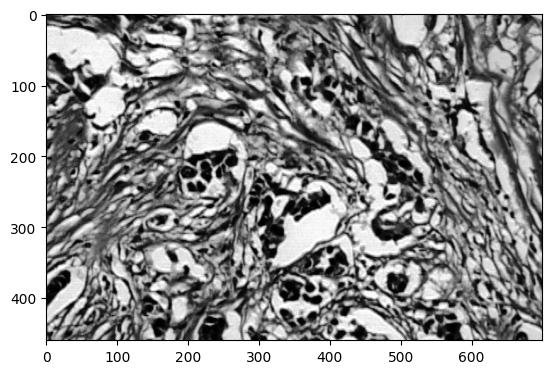

In [49]:
color = plt.imread(train_data[0])
gray = rgb2gray(color)
conversion = img_as_ubyte(gray)
equalized = histogram_equalization(conversion)
plt.imshow(equalized, cmap='gray')

In [50]:
training_images = load_images(train_data[:10])

In [51]:
print(training_images[0])

[[ 39  47  58 ... 210 206 174]
 [ 13  11  25 ... 213 207 205]
 [ 13  28  34 ... 213 210 208]
 ...
 [138 171 149 ... 210 209 225]
 [146 169 143 ... 211 211 213]
 [171 183 145 ... 211 207 221]]


In [52]:
# os.listdir('/content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X')

In [53]:
next_directory

'/content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-004.png'

In [54]:
from skimage.feature import hog

In [55]:
from scipy import signal
from scipy.ndimage import convolve

""" create a 2-D gaussian blurr filter for a given mean and std """
def create_2d_gaussian(size=9, std=1.5):
    gaussian_1d = signal.gaussian(size,std=std)
    gaussian_2d = np.outer(gaussian_1d, gaussian_1d)
    gaussian_2d = gaussian_2d/(gaussian_2d.sum())
    return gaussian_2d

In [56]:
def sharpen_image(image):
  # Blur filter from previous work
  h = np.array([[0.0751, 0.1238, 0.0751], 
              [0.1238, 0.2042, 0.1238],
              [0.0751, 0.1238, 0.0751]])
  blurred_image = convolve(image, h)
  high_frequency_image = np.subtract(image, blurred_image)
  sharpened_image = np.add(image, high_frequency_image)
  return sharpened_image

In [57]:
def edge_detection(image):
  # Construct a HOG for each image and edge detection

  filter = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
  gradients = sc.ndimage.convolve(image, filter)

  histograms = hog(image, orientations = 7, pixels_per_cell=(16,16))

  return gradients, histograms

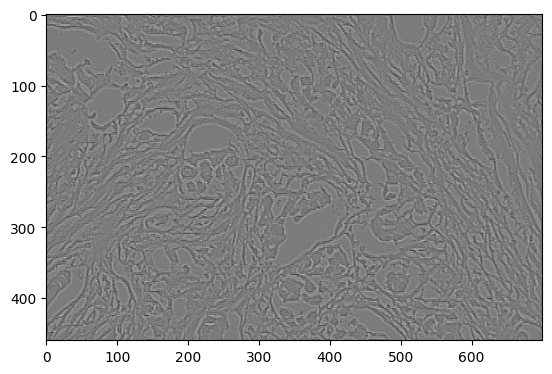

In [58]:
edge = plt.imread(train_data[0])
detection = rgb2gray(edge)
grad, histogram = edge_detection(detection)
plt.imshow(grad, cmap='gray');

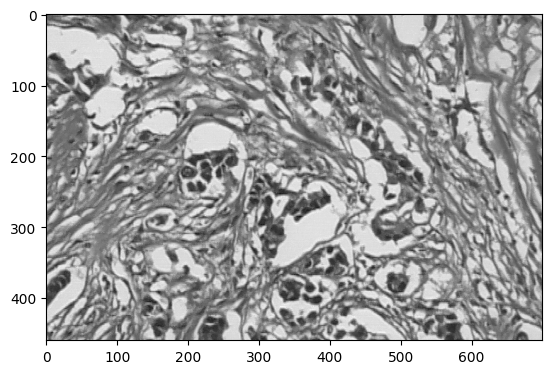

In [59]:
edge = plt.imread(train_data[0])
detection = rgb2gray(edge)
contrast = sharpen_image(detection)
plt.imshow(contrast, cmap='gray');

## Creating Models

In [60]:
### Baseline TensorFlow model
def create_baseline_cnn(input_shape = (460,700), hidden_layers = 0, filters = 4, kernel_size = 3, learning_rate = 0.001, embedding_size = 0):
  
  input_layer = tf.keras.layers.Input(input_shape, batch_size=3, name="Input_Layer")
  convolve_layer = tf.keras.layers.Conv1D(filters=5, kernel_size=3, activation='relu')(input_layer)
  drop_layer = tf.keras.layers.Dropout(0.03)(convolve_layer)
  convolve_layer_2 = tf.keras.layers.Conv1D(filters= filters, kernel_size=3, activation='relu')(drop_layer)
  flatten = tf.keras.layers.Flatten()(convolve_layer_2)
  compress = tf.keras.layers.Dense(1, activation='sigmoid')(flatten)
  base_model = tf.keras.Model(inputs=[input_layer], outputs=[compress])
  base_model.compile(optimizer='sgd', loss="binary_crossentropy", metrics=["accuracy"])

  return base_model

In [61]:
### Baseline Average CNN Model
def create_average_cnn(input_shape = (460, 700), hidden_layers = 3, filters = 3, kernel_size = 3, learning_rate = 0.001, dropout_rate = 0.1):

  input_layer = tf.keras.layers.Input(shape=input_shape, batch_size = 3, name="Starting_Layer")

  # for i in range(hidden_layers):
  input_layer = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation="ReLU", name = "Average_layer")(input_layer)
  avg_layer = tf.keras.layers.AveragePooling1D()(input_layer)
  convolve2 = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation="ReLU")(avg_layer)
  avg_layer = tf.keras.layers.AveragePooling1D()(convolve2)
  avg_layer = tf.keras.layers.Dropout(dropout_rate)(avg_layer)
  global_average_layer = tf.keras.layers.GlobalAveragePooling1D()(avg_layer)
  # flatten_layer = tf.keras.layers.Flatten()(global_average_layer)
  avg_layer = tf.keras.layers.Dropout(dropout_rate)(global_average_layer)
  compress_layer = tf.keras.layers.Dense(128, activation = "ReLU")(avg_layer)
  classification_layer = tf.keras.layers.Dense(1, activation = "sigmoid")(compress_layer)
  model = tf.keras.Model(inputs=[input_layer], outputs=[classification_layer])

  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
                                 loss = "binary_crossentropy",
                                 metrics=["accuracy", tf.keras.metrics.Precision()])
  return model

In [63]:
def create_max_cnn_model(input_shape = (460,700), hidden_layers=3, filters=5, kernel_size=3, learning_rate=0.001, dropout_rate=0.1):

  input_layer = tf.keras.layers.Input(input_shape, batch_size=32, name="Starting_Layer", dtype=tf.float64)
  convolve_1 = tf.keras.layers.Conv1D(filters, kernel_size, padding='valid', activation='relu')(input_layer)
  max_1 = tf.keras.layers.MaxPool1D()(convolve_1)
  convolve_2 = tf.keras.layers.Conv1D(filters, kernel_size, padding='valid', activation='relu')(max_1)
  max_2 = tf.keras.layers.MaxPool1D()(convolve_2)
  slight_adjustment = tf.keras.layers.Dropout(dropout_rate)(max_2)

  flatten = tf.keras.layers.GlobalMaxPooling1D()(slight_adjustment)
  compress = tf.keras.layers.Dense(1, activation='sigmoid')(flatten)
  model = tf.keras.Model(inputs=[input_layer], outputs=[compress])

  model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate),
                loss = tf.keras.losses.binary_crossentropy(),
                metrics = ['Accuracy', tf.keras.metrics.Precision()])
  
  return model



In [64]:
baseline_cnn_model = create_baseline_cnn()

In [65]:
average_cnn_model = create_average_cnn()

In [76]:
max_cnn_model = create_max_cnn_model()

In [67]:
np.asarray(training_images).shape

(10, 460, 700)

## Training Models

In [75]:
training_images = load_images(train_data)

In [251]:
print(train_data[500])

/content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-40-003.png


In [77]:
# training_images = tf.convert_to_tensor(training_images)
# training_images = np.array(training_images, dtype=np.float64)
# [i.shape for i in training_images]
fixed_training_images = np.stack(training_images, axis=2)

ValueError: ignored

In [89]:
fixed_training_images = np.asarray(training_images, dtype='object')
fixed_training_images = tf.convert_to_tensor(fixed_training_images)

ValueError: ignored

In [87]:
baseline_cnn_model.fit(np.asarray(training_images), train_labels[:10], batch_size=32, epochs=10)

<ipython-input-87-9916a26c3b04>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  baseline_cnn_model.fit(np.asarray(training_images), train_labels[:10], batch_size=32, epochs=10)


ValueError: ignored

In [71]:
baseline_cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(3, 460, 700)]           0         
                                                                 
 conv1d (Conv1D)             (3, 458, 5)               10505     
                                                                 
 dropout (Dropout)           (3, 458, 5)               0         
                                                                 
 conv1d_1 (Conv1D)           (3, 456, 4)               64        
                                                                 
 flatten (Flatten)           (3, 1824)                 0         
                                                                 
 dense (Dense)               (3, 1)                    1825      
                                                                 
Total params: 12,394
Trainable params: 12,394
Non-trainable p

In [72]:
average_cnn_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(3, 458, 3)]             0         
                                                                 
 average_pooling1d (AverageP  (3, 229, 3)              0         
 ooling1D)                                                       
                                                                 
 conv1d_2 (Conv1D)           (3, 227, 3)               30        
                                                                 
 average_pooling1d_1 (Averag  (3, 113, 3)              0         
 ePooling1D)                                                     
                                                                 
 dropout_1 (Dropout)         (3, 113, 3)               0         
                                                                 
 global_average_pooling1d (G  (3, 3)                   0   

In [73]:
resized_images = np.array([np.resize(i, (458,3)) for i in training_images])
resized_images

array([[[ 39,  47,  58],
        [ 65,  65,  47],
        [ 93,  65,  87],
        ...,
        [116, 116, 119],
        [123, 117,  93],
        [ 39,  20,  16]],

       [[115, 137, 178],
        [199, 215, 224],
        [229, 235, 235],
        ...,
        [ 60,  88, 132],
        [157, 154, 193],
        [189, 202, 204]],

       [[152, 161, 161],
        [157, 157, 157],
        [157, 157, 164],
        ...,
        [ 54,  70, 117],
        [124, 117, 131],
        [131, 143, 147]],

       ...,

       [[ 43,  53,  68],
        [ 67,  68,  73],
        [ 74,  74,  70],
        ...,
        [ 50,  43,  30],
        [ 30,  28,  34],
        [ 48,  52,  56]],

       [[ 88,  85,  56],
        [ 14,   9,  11],
        [ 36,  45,  61],
        ...,
        [240, 240, 239],
        [237, 234, 231],
        [226, 223, 226]],

       [[140, 166, 140],
        [122,  87,  68],
        [ 66,  84,  87],
        ...,
        [ 60,  73,  75],
        [ 52,  50,  36],
        [ 47,  60,  78]]

In [74]:
average_cnn_model.fit(resized_images, train_labels[:10], batch_size=8, epochs=2) 

Epoch 1/2
2/2 [==============================] - 1s 14ms/step - loss: 1.8254 - accuracy: 0.4000 - precision: 0.4000
Epoch 2/2
2/2 [==============================] - 0s 11ms/step - loss: 1.7038 - accuracy: 0.5000 - precision: 0.4444
